In [1]:
!nvidia-smi

Wed Jun  4 09:17:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# warning disable
import warnings
warnings.filterwarnings("ignore")

In [3]:
!pip install koreanize-matplotlib
!apt-get install -y fonts-nanum*

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 105.4 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'fonts-nanum-extra' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-coding' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-eco' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum' for glob 'fonts-nanum*'
The following NEW packages will be installed:
  fonts-nanum fonts-nanum-coding fonts-nanum-eco fonts-nanum-extra
0 upgraded, 4 newly installed, 0 to remove and 35 not upgraded.
Need to get 46.0 MB of archives.
After this operation, 177 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum-coding all 2.5-3 [4,988 B]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum-eco all 1.000-7 [14.7 MB]
Get:4 http://archive

In [4]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files

import koreanize_matplotlib

Mounted at /content/drive


In [ ]:
#import matplotlib
#matplotlib.rcParams['font.family'] = 'AppleGothic'
#matplotlib.rcParams['axes.unicode_minus'] = False

In [5]:
# import packages
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack
import joblib

In [6]:
# 1. Load dataset
path = "/content/drive/MyDrive/cloud/data_3.csv"
df = pd.read_csv(path)

In [6]:
df

,사업자등록번호,관할세무서코드,개인법인구분,과세유형코드,상호명,기업규모,시도명,취급품목,산업분류코드
0,1010106624,101,개인,2,개인택시,미확인,서울,NaN,H49
1,1010108807,101,개인,2,코리아 콜밴,미확인,서울,NaN,H52
2,1010109048,101,개인,1,부동산임대(김은숙),미확인,서울,NaN,I56
3,1010109223,101,개인,1,한국황토건축연구소,미확인,서울,NaN,I56
4,1010109257,101,개인,1,PENIEL,미확인,서울,NaN,I56
...,...,...,...,...,...,...,...,...,...
3016778,8999901437,899,개인,4,기탄사고력교실 명지중흥점,미확인,부산,NaN,P85
3016779,8999901456,899,개인,4,금강흑염소농장,소기업(소상공인),충북,NaN,G47
3016780,8999901475,899,개인,4,나디아킴 음악교습소,미확인,경기,NaN,P85
3016781,9078401016,907,법인,4,한독상공회의소,미확인,서울,NaN,S94


In [7]:
# 2. Preprocess data
text_col = "상호명"
target_col = "산업분류코드"
categorical_cols = ["관할세무서코드", "개인법인구분", "과세유형코드", "기업규모", "시도명"]
multilabel_col = "취급품목"

# Filter necessary columns
columns_needed = [text_col, target_col] + categorical_cols + [multilabel_col]
df = df[columns_needed]

# Fill missing values
for col in categorical_cols:
    df[col] = df[col].fillna("Unknown")
df[text_col] = df[text_col].fillna("")
df[multilabel_col] = df[multilabel_col].fillna("Unknown")
df = df.dropna(subset=[target_col])

# Remove classes with fewer than 2 samples
y_counts = df[target_col].value_counts()
valid_classes = y_counts[y_counts >= 2].index
df = df[df[target_col].isin(valid_classes)]

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df[target_col].astype(str))

In [8]:
# 3. Text vectorization
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_text = vectorizer.fit_transform(df[text_col])

# 4. One-hot encode categorical features
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
X_cat = encoder.fit_transform(df[categorical_cols])

# 4.1 Multi-label encode 취급품목
from sklearn.preprocessing import MultiLabelBinarizer

df["취급품목_list"] = df[multilabel_col].apply(lambda x: x.split())
mlb = MultiLabelBinarizer()
X_items = mlb.fit_transform(df["취급품목_list"])

# Combine features
X = hstack([X_text, X_cat, X_items])

# 5. Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Cross-validation splitter
cv_splitter = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

results = []

# Utility function for evaluation
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    print("" + "=" * 50)
    print(f"모델 평가 리포트 - {name}")
    print("정확도와 각 산업분류코드별 정밀도(precision), 재현율(recall), F1 점수:")
    print(classification_report(
        label_encoder.inverse_transform(y_test),
        label_encoder.inverse_transform(y_pred)
    ))
    labels = sorted(np.unique(np.concatenate((y_test, y_pred))))
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=label_encoder.inverse_transform(labels)
    )
    disp.plot(xticks_rotation='vertical', cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.tight_layout()
    plt.show()
    return acc, f1

Fitting 2 folds for each of 6 candidates, totalling 12 fits
모델 평가 리포트 - XGBoost
정확도와 각 산업분류코드별 정밀도(precision), 재현율(recall), F1 점수:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         C13       0.67      0.06      0.11      1393
         C14       0.56      0.08      0.14     19179
         C21       0.72      0.06      0.10      5372
         D35       0.00      0.00      0.00         5
         G45       0.61      0.08      0.13      6359
         G46       0.42      0.01      0.01      1422
         G47       0.50      0.50      0.50    189297
         H49       0.79      0.80      0.79      7597
         H50       0.00      0.00      0.00       185
         H51       0.33      0.06      0.10        17
         H52       0.68      0.16      0.25      6293
         I55       0.85      0.11      0.20      8989
         I56       0.43      0.82      0.57    161458
         J58       0.47      0.03      0.05      4588
         J59       0.41      0.04      0.08      1025
         J60       0.00      0.00      0.00        22
         J61       0.00      0.00      0.00       562
         K64       0.00    

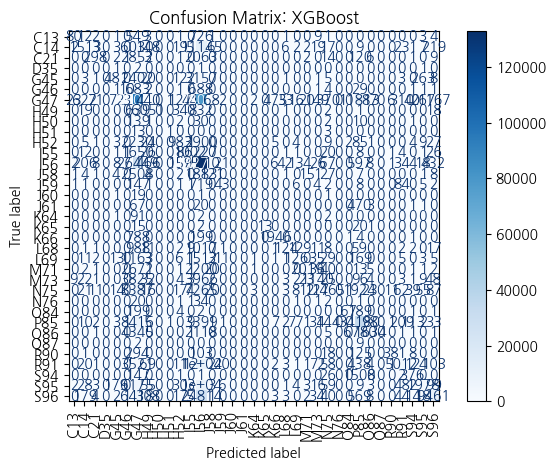

gs_xgb 객체가 gs_xgb_gridsearchcv3.pkl 파일로 저장되었습니다.


In [9]:
# 6. GridSearchCV for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'tree_method': ['gpu_hist'],
    'predictor': ['gpu_predictor']
}
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', verbosity=0)
start_xgb = time.time()
gs_xgb = GridSearchCV(xgb_model, param_grid_xgb, scoring='f1_macro', cv=cv_splitter, verbose=1, n_jobs=-1)
gs_xgb.fit(X_train, y_train)
time_xgb = time.time() - start_xgb
acc_xgb, f1_xgb = evaluate_model("XGBoost", gs_xgb.best_estimator_, X_test, y_test)
results.append(["XGBoost_GridSearchCV", acc_xgb, f1_xgb, time_xgb])

# XGBoost GridSearchCV 객체 저장
joblib.dump(gs_xgb, "/content/drive/MyDrive/cloud/gs_xgb_gridsearchcv3.pkl")
print("gs_xgb 객체가 gs_xgb_gridsearchcv3.pkl 파일로 저장되었습니다.")
# 32min

Fitting 2 folds for each of 6 candidates, totalling 12 fits
모델 평가 리포트 - LightGBM
정확도와 각 산업분류코드별 정밀도(precision), 재현율(recall), F1 점수:
              precision    recall  f1-score   support

         C13       0.00      0.00      0.00      1393
         C14       0.10      0.06      0.07     19179
         C21       0.00      0.00      0.00      5372
         D35       0.00      0.00      0.00         5
         G45       0.00      0.00      0.00      6359
         G46       0.00      0.00      0.00      1422
         G47       0.45      0.00      0.00    189297
         H49       0.00      0.00      0.00      7597
         H50       0.00      0.00      0.00       185
         H51       0.00      0.00      0.00        17
         H52       0.03      0.00      0.00      6293
         I55       0.00      0.00      0.00      8989
         I56       0.08      0.00      0.00    161458
         J58       0.00      0.00      0.00      4588
         J59       0.00      0.00      0.00      1025
   

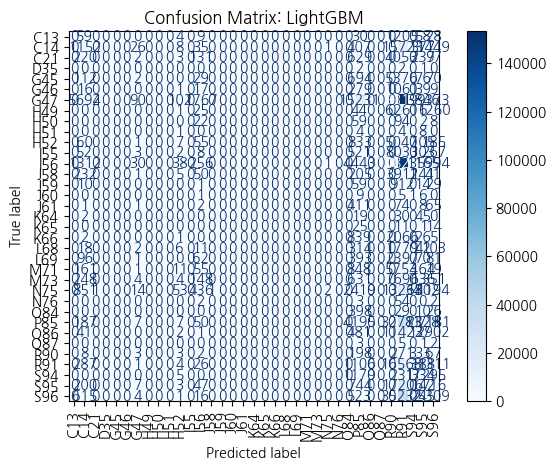

gs_lgb 객체가 gs_lgb_gridsearchcv3.pkl 파일로 저장되었습니다.


In [9]:
# 7. GridSearchCV for LightGBM
param_grid_lgb = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7, 9]
}
lgb_model = lgb.LGBMClassifier(verbose=-1)
start_lgb = time.time()
gs_lgb = GridSearchCV(lgb_model, param_grid_lgb, scoring='f1_macro', cv=cv_splitter, verbose=1, n_jobs=-1)
gs_lgb.fit(X_train, y_train)
time_lgb = time.time() - start_lgb
acc_lgb, f1_lgb = evaluate_model("LightGBM", gs_lgb.best_estimator_, X_test, y_test)
results.append(["LightGBM_GridSearchCV", acc_lgb, f1_lgb, time_lgb])

# LightGBM GridSearchCV 객체 저장
joblib.dump(gs_lgb, "/content/drive/MyDrive/cloud/gs_lgb_gridsearchcv3.pkl")
print("gs_lgb 객체가 gs_lgb_gridsearchcv3.pkl 파일로 저장되었습니다.")
# 60min

Fitting 2 folds for each of 2 candidates, totalling 4 fits
모델 평가 리포트 - RandomForest
정확도와 각 산업분류코드별 정밀도(precision), 재현율(recall), F1 점수:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         C13       0.00      0.00      0.00      1393
         C14       0.00      0.00      0.00     19179
         C21       0.00      0.00      0.00      5372
         D35       0.00      0.00      0.00         5
         G45       0.00      0.00      0.00      6359
         G46       0.00      0.00      0.00      1422
         G47       0.34      0.97      0.50    189297
         H49       0.95      0.61      0.74      7597
         H50       0.00      0.00      0.00       185
         H51       0.00      0.00      0.00        17
         H52       0.00      0.00      0.00      6293
         I55       1.00      0.00      0.00      8989
         I56       0.60      0.16      0.26    161458
         J58       0.00      0.00      0.00      4588
         J59       0.00      0.00      0.00      1025
         J60       0.00      0.00      0.00        22
         J61       0.00      0.00      0.00       562
         K64       0.00    

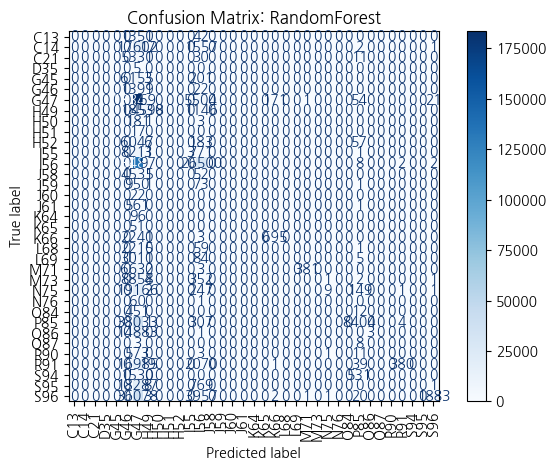

gs_rf 객체가 gs_rf_gridsearchcv3.pkl 파일로 저장되었습니다.


In [10]:
# 8. GridSearchCV for RandomForest
#param_grid_rf = {
#    'n_estimators': [100, 200],
#    'max_depth': [10, 20, None]
#}
# System Crash를 방지하기 위해 HyperParam 축소
param_grid_rf = {
    'n_estimators': [100],
    'max_depth': [10, 20]
}
rf_model = RandomForestClassifier()
start_rf = time.time()
#gs_rf = GridSearchCV(rf_model, param_grid_rf, scoring='f1_macro', cv=cv_splitter, verbose=1, n_jobs=-1)
# System Crash를 방지하기 위해 n_jobs를 1로 고정
gs_rf = GridSearchCV(rf_model, param_grid_rf, scoring='f1_macro', cv=cv_splitter, verbose=1, n_jobs=1)
gs_rf.fit(X_train, y_train)
time_rf = time.time() - start_rf
acc_rf, f1_rf = evaluate_model("RandomForest", gs_rf.best_estimator_, X_test, y_test)
results.append(["RandomForest_GridSearchCV", acc_rf, f1_rf, time_rf])

# RandomForest GridSearchCV 객체 저장
joblib.dump(gs_rf, "/content/drive/MyDrive/cloud/gs_rf_gridsearchcv3.pkl")
print("gs_rf 객체가 gs_rf_gridsearchcv3.pkl 파일로 저장되었습니다.")
# 7min

In [10]:
# 9. Summary

# 저장된 GridSearchCV 객체 불러오기
gs_xgb_loaded = joblib.load("/content/drive/MyDrive/cloud/gs_xgb_gridsearchcv3.pkl")
gs_lgb_loaded = joblib.load("/content/drive/MyDrive/cloud/gs_lgb_gridsearchcv3.pkl")
gs_rf_loaded = joblib.load("/content/drive/MyDrive/cloud/gs_rf_gridsearchcv3.pkl")

# 각 모델의 테스트셋 성능 측정
y_pred_xgb = gs_xgb_loaded.best_estimator_.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb, average='macro')

y_pred_lgb = gs_lgb_loaded.best_estimator_.predict(X_test)
acc_lgb = accuracy_score(y_test, y_pred_lgb)
f1_lgb = f1_score(y_test, y_pred_lgb, average='macro')

y_pred_rf = gs_rf_loaded.best_estimator_.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='macro')

# 요약 테이블 생성
summary_df = pd.DataFrame({
    "Model": ["XGBoost_GridSearchCV", "LightGBM_GridSearchCV", "RandomForest_GridSearchCV"],
    "Accuracy": [acc_xgb, acc_lgb, acc_rf],
    "F1_Score": [f1_xgb, f1_lgb, f1_rf]
})

print("=" * 50)
print("저장된 pkl 파일을 활용한 모델별 성능 요약:")
print(summary_df.sort_values(by="Accuracy", ascending=False))

# 가장 정확도가 높은 모델 찾기
best_idx = summary_df["Accuracy"].idxmax()
best_row = summary_df.loc[best_idx]
print("\n가장 성능이 좋은 모델(정확도 기준):")
print(best_row)

저장된 pkl 파일을 활용한 모델별 성능 요약:
                       Model  Accuracy  F1_Score
0       XGBoost_GridSearchCV  0.493946  0.215355
2  RandomForest_GridSearchCV  0.375123  0.068387
1      LightGBM_GridSearchCV  0.045973  0.011457

가장 성능이 좋은 모델(정확도 기준):
Model       XGBoost_GridSearchCV
Accuracy                0.493946
F1_Score                0.215355
Name: 0, dtype: object


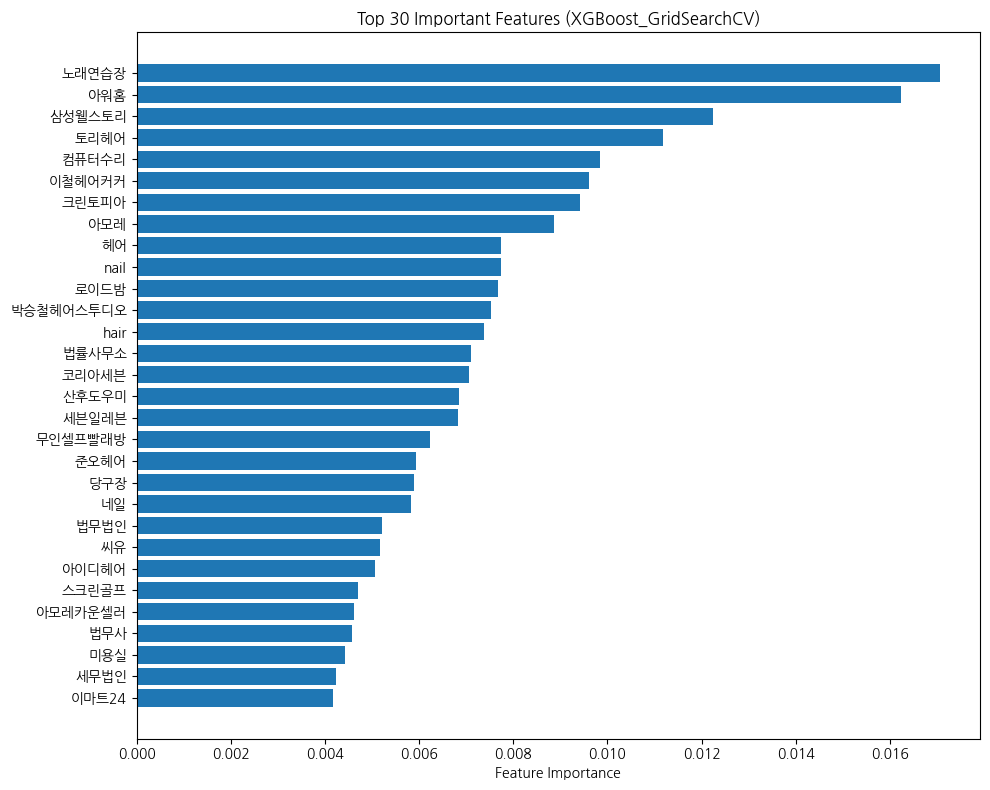

In [12]:
# 10. Feature Importance (from best accuracy model)
best_model_name = best_row["Model"]

if best_model_name == "XGBoost_GridSearchCV":
    best_model = gs_xgb_loaded.best_estimator_
elif best_model_name == "LightGBM_GridSearchCV":
    best_model = gs_lgb_loaded.best_estimator_
elif best_model_name == "RandomForest_GridSearchCV":
    best_model = gs_rf_loaded.best_estimator_
else:
    best_model = None

if best_model is not None and hasattr(best_model, "feature_importances_"):
    feature_names = vectorizer.get_feature_names_out().tolist() + encoder.get_feature_names_out(categorical_cols).tolist() + mlb.classes_.tolist() # Include features from MultiLabelBinarizer
    importances = best_model.feature_importances_
    # Ensure we don't try to access more features than exist
    num_features_to_show = min(30, len(feature_names))
    indices = np.argsort(importances)[-num_features_to_show:][::-1]  # Top features

    plt.figure(figsize=(10, 8))
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel("Feature Importance")
    plt.title(f"Top {num_features_to_show} Important Features ({best_model_name})")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("선택된 모델에서 feature_importances_를 지원하지 않습니다.")